# Rerandomization to Improve Covariate Balance in Experiments

**Authors**: Based on Morgan & Rubin (2012)

---

## Table of Contents
1. [The Problem](#problem)
2. [The Solution: Rerandomization](#solution)
3. [Mahalanobis Distance Criterion](#mahalanobis)
4. [Implementation](#implementation)
5. [Power Analysis](#power)
6. [Comparison: Pure vs. Rerandomization](#comparison)

---

## 1. The Problem <a id='problem'></a>

### Why Pure Randomization Can Fail

Randomized experiments are the "gold standard" for causal inference. However, **pure randomization only balances covariates on average**. In any single experiment, chance imbalances can occur.

#### Example Scenario
Suppose you're testing a new blood pressure medication with 40 patients. You collect baseline data:
- Age
- Baseline systolic BP
- Baseline diastolic BP  
- BMI

**The Problem**: With 4 covariates and α = 0.05, the probability of at least one showing a "significant" imbalance is:

$$P(\text{at least one imbalance}) = 1 - (1-0.05)^4 = 0.185 = 18.5\%$$

Nearly 1 in 5 experiments would start with suspicious covariate imbalance!

#### What Could Go Wrong

**Pure Randomization Result**:
- **Treatment group**: Average baseline BP = 155 mmHg
- **Control group**: Average baseline BP = 142 mmHg
- **Imbalance**: 13 mmHg difference before treatment!

**At Study End**:
- Treatment group: 145 mmHg (reduced by 10)
- Control group: 138 mmHg (reduced by 4)
- Observed difference: 7 mmHg

**Question**: Did the treatment cause 7 mmHg reduction, or is it just because the treatment group started higher and regressed to the mean? Hard to tell!

---

## 2. The Solution: Rerandomization <a id='solution'></a>

### The Core Idea

**Instead of accepting whatever randomization you get, keep randomizing until you get good covariate balance!**

### The Process

1. **Collect covariate data** (before the experiment)
2. **Specify a balance criterion** φ(X, W) in advance
3. **Randomize** units to treatment/control
4. **Check balance**: Does this randomization satisfy φ?
   - If YES → Use this randomization
   - If NO → Go back to step 3
5. **Run the experiment** with the accepted randomization
6. **Analyze with randomization test** (accounting for the selection process)

### Requirements

**Pre-specify the criterion**: Must decide φ before randomizing

**Symmetric criterion**: φ(X, W) = φ(X, 1-W) (treats groups equally)

**Use randomization tests**: Standard t-tests become invalid

### Benefits

**Better covariate balance** (by design)

**More precise treatment effect estimates** (when covariates predict outcomes)

**Higher power** / narrower confidence intervals

**Valid inference** (via randomization tests)

### When Does It Help Most?

The variance reduction in the treatment effect estimate is:

$$\text{Variance Reduction} = (1 - v_a) \times R^2$$

Where:
- $v_a$: Factor by which covariate variance is reduced (depends on how strict your criterion is)
- $R^2$: Proportion of outcome variance explained by covariates

**For Example**: If $v_a = 0.4$ (60% covariate variance reduction) and $R^2 = 0.6$ (covariates explain 60% of outcome):
- Variance reduction = $(1 - 0.4) \times 0.6 = 0.36 = 36\%$
- Standard error reduced by ~25%
- Confidence intervals ~25% narrower!

---

## 3. Mahalanobis Distance Criterion <a id='mahalanobis'></a>

### Why Mahalanobis Distance?

We need a criterion φ to determine if a randomization is "balanced".

A simple approach would be to bound each covariate separately:

**Problems**:
1. **Scale dependent**:
   Decision changes if the scale of measurement changes
2. **Ignores correlations**:
   Treat covariates differently
3. **Multiple dimensions**:
   Hard to balance 10+ covariates this way

### Mahalanobis Distance:

**Definition**: A multivariate distance measure that accounts for correlations and scales.

$$M = n \cdot p_w \cdot (1-p_w) \cdot (\bar{X}_T - \bar{X}_C)^T \Sigma^{-1} (\bar{X}_T - \bar{X}_C)$$

Where:
- $(\bar{X}_T - \bar{X}_C)$: Vector of covariate mean differences between treatment and control
- $\Sigma$: Sample covariance matrix of covariates
- $\Sigma^{-1}$: Inverse covariance matrix (accounts for correlations and scales)
- $n$: Total sample size
- $p_w$: Proportion assigned to treatment (usually 0.5)

### Advantages

**Scale invariant**:Measuring any covariate in different scale gives same M

**Accounts for correlations**: Correlations among variables are accounted for

**Single summary measure**: One number to check instead of k individual conditions

**Known distribution**: Under pure randomization, $M \sim \chi^2_k$ (chi-squared with k degrees of freedom)

### Setting the Threshold

**Goal**: Accept the top $p_a$ proportion of most balanced randomizations.

**Method**: Find threshold $a$ such that $P(\chi^2_k \leq a) = p_a$

**Example**:
- k = 5 covariates
- Want to accept top 20% most balanced ($p_a = 0.20$)
- From $\chi^2_5$ table: $a = 4.35$
- **Criterion**: Accept if $M < 4.35$

### Variance Reduction Factor

The factor by which rerandomization reduces variance is:

$$v_a = \frac{2}{k} \cdot \frac{\gamma(k/2 + 1, a/2)}{\gamma(k/2, a/2)} = \frac{P(\chi^2_{k+2} \leq a)}{P(\chi^2_k \leq a)}$$

Where $\gamma$ is the incomplete gamma function.

---

## 4. Implementation <a id='implementation'></a>

# This section to be removed later:-


Write core functions:-



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2
from scipy.linalg import sqrtm
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)

In [5]:
 def generate_data(n=200, k=8, true_effect=5.0, R_squared=0.6, seed=42):
    np.random.seed(seed)
    corr = np.eye(k)
    for i in range(k):
        for j in range(i+1, k):
            corr[i, j] = corr[j, i] = np.random.uniform(0.1, 0.4)

    X = np.random.multivariate_normal(np.zeros(k), corr, size=n)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Outcome model

    beta = np.random.uniform(0.5, 2.0, k)
    beta = beta / np.linalg.norm(beta) * np.sqrt(k)
    signal = X @ beta
    signal_var = np.var(signal)
    noise_var = signal_var * (1 - R_squared) / R_squared
    noise = np.random.normal(0, np.sqrt(noise_var), n)
    y_control = 50 + signal + noise
    y_treat = y_control + true_effect
    covariate_names = [f'x{i+1}' for i in range(k)]
    return X, y_control, y_treat, covariate_names

# Generate dataset (Try to generate different combinations of the data by changing the specifications here)

X, y_control, y_treat, names = generate_data(
    n=200, k=8, true_effect=5.0, R_squared=0.6, seed=42
)

In [11]:
df = pd.DataFrame(X, columns=names)
print("\Summary Statistics:")
print(df.describe().round(1))

\Summary Statistics:
          x1     x2     x3     x4     x5     x6     x7     x8
count  200.0  200.0  200.0  200.0  200.0  200.0  200.0  200.0
mean     0.0    0.0    0.0   -0.0    0.0    0.0   -0.0   -0.0
std      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
min     -2.4   -2.2   -2.6   -2.8   -2.2   -3.0   -2.3   -2.4
25%     -0.8   -0.7   -0.7   -0.6   -0.7   -0.6   -0.6   -0.7
50%     -0.0   -0.0   -0.0   -0.0    0.0    0.0   -0.1   -0.0
75%      0.7    0.7    0.7    0.6    0.6    0.7    0.7    0.7
max      2.7    3.0    3.9    2.8    2.9    2.9    2.7    2.7


In [ ]:
def calculate_mahalanobis_distance(X, W):
    """Calculate Mahalanobis distance for covariate balance."""
    n = len(W)
    n_treat = int(np.sum(W))
    p_w = n_treat / n

    X_treat = X[W == 1].mean(axis=0)
    X_control = X[W == 0].mean(axis=0)
    diff = X_treat - X_control

    Sigma = np.cov(X.T)
    if X.shape[1] == 1:
        Sigma_inv = 1 / Sigma
    else:
        Sigma_inv = np.linalg.pinv(Sigma)

    M = n * p_w * (1 - p_w) * diff.T @ Sigma_inv @ diff
    return M

In [19]:
def calculate_v_a(k, p_a):
    """Calculate variance reduction factor."""
    a = chi2.ppf(p_a, df=k)
    v_a = chi2.cdf(a, df=k+2) / chi2.cdf(a, df=k)
    return v_a

In [20]:
def rerandomize(X, n_treat, p_a, max_attempts=10000):
    """Perform rerandomization to achieve balance."""
    n, k = X.shape
    threshold = chi2.ppf(p_a, df=k)

    for attempt in range(max_attempts):
        W = np.zeros(n)
        treat_indices = np.random.choice(n, size=n_treat, replace=False)
        W[treat_indices] = 1

        M = calculate_mahalanobis_distance(X, W)

        if M <= threshold:
            return W, M, attempt + 1

    raise ValueError(f"No acceptable randomization found in {max_attempts} attempts")

In [21]:
def randomization_test(X, W, y, p_a, n_simulations=5000):
    """Perform randomization test accounting for rerandomization."""
    n = len(y)
    n_treat = int(np.sum(W))
    k = X.shape[1]
    threshold = chi2.ppf(p_a, df=k)

    obs_diff = y[W == 1].mean() - y[W == 0].mean()

    null_diffs = []
    attempts = 0

    while len(null_diffs) < n_simulations:
        attempts += 1
        W_sim = np.zeros(n)
        treat_indices = np.random.choice(n, size=n_treat, replace=False)
        W_sim[treat_indices] = 1

        M = calculate_mahalanobis_distance(X, W_sim)

        if M <= threshold:
            diff = y[W_sim == 1].mean() - y[W_sim == 0].mean()
            null_diffs.append(diff)

    null_diffs = np.array(null_diffs)
    p_value = np.mean(np.abs(null_diffs) >= np.abs(obs_diff))

    return p_value, null_diffs

In [24]:
def calculate_actual_R_squared(X, y):
    """Calculate actual R² from data."""
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X, y)
    return model.score(X, y)

In [23]:
def simulate_power(X, y_control, y_treat, p_a, n_trials=500, alpha=0.05):
    """Simulate statistical power for given scenario."""
    n = len(y_control)
    n_treat = n // 2
    k = X.shape[1]

    rejections = 0

    for _ in range(n_trials):
        if p_a < 1.0:
            W, _, _ = rerandomize(X, n_treat, p_a)
        else:
            W = np.zeros(n)
            treat_idx = np.random.choice(n, size=n_treat, replace=False)
            W[treat_idx] = 1

        y_obs = y_treat * W + y_control * (1 - W)
        p_value, _ = randomization_test(X, W, y_obs, p_a, n_simulations=500)

        if p_value < alpha:
            rejections += 1

    power = rejections / n_trials
    return power

### Step 1: Pure Randomization

In [33]:
covariates = df
X = covariates.values
n = X.shape[0]
k = X.shape[1]
covariate_names = [f'x{i+1}' for i in range(k)]
n_treat = int(n / 2)
np.random.seed(123)
W_pure = np.zeros(n)
treat_indices = np.random.choice(n, size=n_treat, replace=False)
W_pure[treat_indices] = 1
M_pure = calculate_mahalanobis_distance(X, W_pure)
X_treat_pure = X[W_pure == 1].mean(axis=0)
X_control_pure = X[W_pure == 0].mean(axis=0)
diff_pure = X_treat_pure - X_control_pure
print("="*70)
print(f"\nMahalanobis Distance: {M_pure:.3f}")
print(f"\nCovariate Balance:")
print("-" * 70)
print(f"{'Covariate':<20} {'Treatment':<15} {'Control':<15} {'Difference':<15}")
print("-" * 70)
for i, name in enumerate(covariate_names):
    print(f"{name:<20} {X_treat_pure[i]:>14.2f} {X_control_pure[i]:>14.2f} {diff_pure[i]:>14.2f}")
print("-" * 70)
print("\n t-tests for covariate balance:")
print("-" * 70)
for i, name in enumerate(covariate_names):
    t_stat, p_val = stats.ttest_ind(X[W_pure==1, i], X[W_pure==0, i])
    sig = "*" if p_val < 0.05 else ""
    print(f"{name:<20} t = {t_stat:>7.3f}, p = {p_val:>6.4f} {sig}")
print("-" * 70)
print("* indicates p < 0.05 (significant imbalance)")



Mahalanobis Distance: 9.902

Covariate Balance:
----------------------------------------------------------------------
Covariate            Treatment       Control         Difference     
----------------------------------------------------------------------
x1                             0.11          -0.11           0.21
x2                             0.01          -0.01           0.01
x3                            -0.12           0.12          -0.23
x4                            -0.07           0.07          -0.15
x5                            -0.01           0.01          -0.01
x6                            -0.06           0.06          -0.11
x7                            -0.00           0.00          -0.01
x8                            -0.01           0.01          -0.01
----------------------------------------------------------------------

 t-tests for covariate balance:
----------------------------------------------------------------------
x1                   t =   1.498, p =

Mahalanobis Distance: The value (9.902 in this run) is a single summary measure of the multivariate distance between the mean vectors of the treatment and control groups, taking into account the covariance between the covariates. Under pure randomization, this value is expected to follow a Chi-squared distribution with degrees of freedom equal to the number of covariates (k=8 in this case). A higher Mahalanobis distance indicates worse overall balance. A value significantly larger than the median of the  𝜒2𝑘  𝜒2𝑘  distribution suggests a notable multivariate imbalance.

Focusing solely on individual p-values can be misleading due to multiple comparisons. The Mahalanobis distance is a better overall measure of multivariate balance.

### Step 2: Rerandomization with Mahalanobis Distance

In [54]:
p_a = 0.20  # Try different values
threshold = chi2.ppf(p_a, df=k)
try:
    np.random.seed(42)
    W_rerand, M_rerand, attempts = rerandomize(X, n_treat, p_a)

    print(f"\nRerandomization successful after {attempts} attempts.")
    print(f"Accepted Mahalanobis distance: {M_rerand:.3f} (Threshold: {threshold:.3f})")
    X_treat_rerand = X[W_rerand == 1].mean(axis=0)
    X_control_rerand = X[W_rerand == 0].mean(axis=0)
    diff_rerand = X_treat_rerand - X_control_rerand
    print("\nMahalanobis Distance:", M_rerand)
    print("\nCovariate Balance:")
    print("-" * 70)
    print(f"{'Covariate':<20} {'Treatment':<15} {'Control':<15} {'Difference':<15}")
    print("-" * 70)
    for i, name in enumerate(covariate_names):
        print(f"{name:<20} {X_treat_rerand[i]:>14.2f} {X_control_rerand[i]:>14.2f} {diff_rerand[i]:>14.2f}")
    print("-" * 70)

    print("\n t-tests for covariate balance:")
    print("-" * 70)
    for i, name in enumerate(covariate_names):
        t_stat, p_val = stats.ttest_ind(X[W_rerand==1, i], X[W_rerand==0, i])
        sig = "*" if p_val < 0.05 else ""
        print(f"{name:<20} t = {t_stat:>7.3f}, p = {p_val:>6.4f} {sig}")
    print("-" * 70)
    print("* indicates p < 0.05 (significant imbalance)")

except ValueError as e:
    print(f"\nError: {e}")
    print("Rerandomization failed. Consider increasing max_attempts in the rerandomize function or increasing p_a.")

TypeError: 'float' object cannot be interpreted as an integer

### Step 3: Run the Experiment and Analyze



Standard Deviation of Treatment Effect Estimates (from simulations):
  Pure Randomization:     0.662
  Rerandomization (p_a=0.2): 0.565

Precision Gain due to Rerandomization: 14.7% reduction in SE


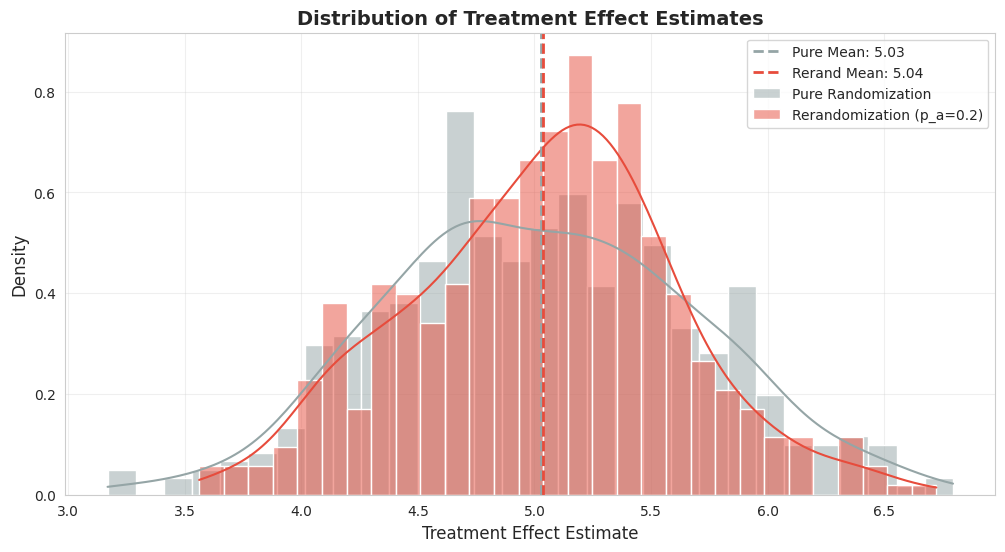

  • The narrower distribution for Rerandomization indicates lower variability
    in the estimated treatment effect across repeated experiments.
  • This lower variability means higher precision.


In [45]:
n_simulations = 500
rerand_test_sims = 500
p_a_compare = 0.20
effect_estimates_pure = []
effect_estimates_rerand = []
for sim in range(n_simulations):
    # Pure randomization
    W_pure_sim = np.zeros(n)
    treat_indices_sim = np.random.choice(n, size=n_treat, replace=False)
    W_pure_sim[treat_indices_sim] = 1
    # Observe outcomes
    y_obs_sim = y_treat * W_pure_sim + y_control * (1 - W_pure_sim)
    # Estimate treatment effect
    effect_est_pure = y_obs_sim[W_pure_sim == 1].mean() - y_obs_sim[W_pure_sim == 0].mean()
    effect_estimates_pure.append(effect_est_pure)

for sim in range(n_simulations):
    try:
        W_rerand_sim, M_sim, attempts = rerandomize(X, n_treat, p_a_compare, max_attempts=10000)
    except ValueError:
        continue
    y_obs_sim = y_treat * W_rerand_sim + y_control * (1 - W_rerand_sim)
    # Estimate treatment effect
    effect_est_rerand = y_obs_sim[W_rerand_sim == 1].mean() - y_obs_sim[W_rerand_sim == 0].mean()
    effect_estimates_rerand.append(effect_est_rerand)
print("\n" + "="*70)
print("="*70)

# Calculate standard deviation of estimates

se_pure_sim = np.std(effect_estimates_pure)
se_rerand_sim = np.std(effect_estimates_rerand)
print(f"\nStandard Deviation of Treatment Effect Estimates (from simulations):")
print(f"  Pure Randomization:     {se_pure_sim:.3f}")
print(f"  Rerandomization (p_a={p_a_compare}): {se_rerand_sim:.3f}")

# Compute precision gain
if se_pure_sim > 0:
    precision_gain_percent = (se_pure_sim - se_rerand_sim) / se_pure_sim * 100
    print(f"\nPrecision Gain due to Rerandomization: {precision_gain_percent:.1f}% reduction in SE")
else:
    print("\nCannot calculate precision gain as SE for pure randomization is zero.")
if len(effect_estimates_pure) > 0 and len(effect_estimates_rerand) > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(effect_estimates_pure, bins=30, color='#95A5A6', label='Pure Randomization', kde=True, stat='density', common_norm=True)
    sns.histplot(effect_estimates_rerand, bins=30, color='#E74C3C', label=f'Rerandomization (p_a={p_a_compare})', kde=True, stat='density', common_norm=True)
    plt.axvline(np.mean(effect_estimates_pure), color='#95A5A6', linestyle='--', linewidth=2, label=f'Pure Mean: {np.mean(effect_estimates_pure):.2f}')
    plt.axvline(np.mean(effect_estimates_rerand), color='#E74C3C', linestyle='--', linewidth=2, label=f'Rerand Mean: {np.mean(effect_estimates_rerand):.2f}')
    plt.xlabel('Treatment Effect Estimate', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Distribution of Treatment Effect Estimates', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    print("  • The narrower distribution for Rerandomization indicates lower variability")
    print("    in the estimated treatment effect across repeated experiments.")
    print("  • This lower variability means higher precision.")

In [52]:
def randomization_test(X, y_control, y_treat, treat, n_simulations=1000, seed=None):
    """
    Computes the treatment effect for a given treatment assignment.
    """
    if seed is not None:
        np.random.seed(seed)

    n = len(treat)
    tau_hat = np.mean(y_treat[treat == 1]) - np.mean(y_control[treat == 0])

    # Compute Mahalanobis distance as a measure of covariate imbalance
    X_treat = X[treat == 1]
    X_control = X[treat == 0]
    X_diff = X_treat.mean(axis=0) - X_control.mean(axis=0)
    cov = np.cov(X.T)
    cov_inv = np.linalg.pinv(cov)
    M = X_diff.T @ cov_inv @ X_diff

    return tau_hat, M


def rerandomize(X, a_threshold, max_iter=5000, seed=None):
    """
    Finds a treatment assignment with Mahalanobis distance below threshold.
    """
    if seed is not None:
        np.random.seed(seed)

    n, k = X.shape
    for _ in range(max_iter):
        treat = np.random.binomial(1, 0.5, n)

        # Compute Mahalanobis distance
        X_treat = X[treat == 1]
        X_control = X[treat == 0]
        if len(X_treat) == 0 or len(X_control) == 0:
            continue  # skip degenerate splits
        X_diff = X_treat.mean(axis=0) - X_control.mean(axis=0)
        cov = np.cov(X.T)
        cov_inv = np.linalg.pinv(cov)
        M = X_diff.T @ cov_inv @ X_diff

        if M <= a_threshold:
            return treat, M, True  # successful rerandomization

    # If no assignment meets threshold, return last one
    return treat, M, False



Simulating case: linear



Simulating case: nonlinear



Simulating case: hidden



Simulating case: truncation



Summary of results:
         Case  Mean τ (pure)  Mean τ (rerand)  Var(τ pure)  Var(τ rerand)  \
0      linear          4.940            4.978        0.669          0.610   
1   nonlinear          4.913            4.974        1.155          1.065   
2      hidden          5.052            4.935        0.898          1.061   
3  truncation          4.940            4.978        0.669          0.610   

   Variance Reduction  Mean M (pure)  Mean M (rerand)  
0               0.088          0.165            0.159  
1               0.078          0.165            0.159  
2              -0.181          0.163            0.160  
3               0.088          0.165            0.159  


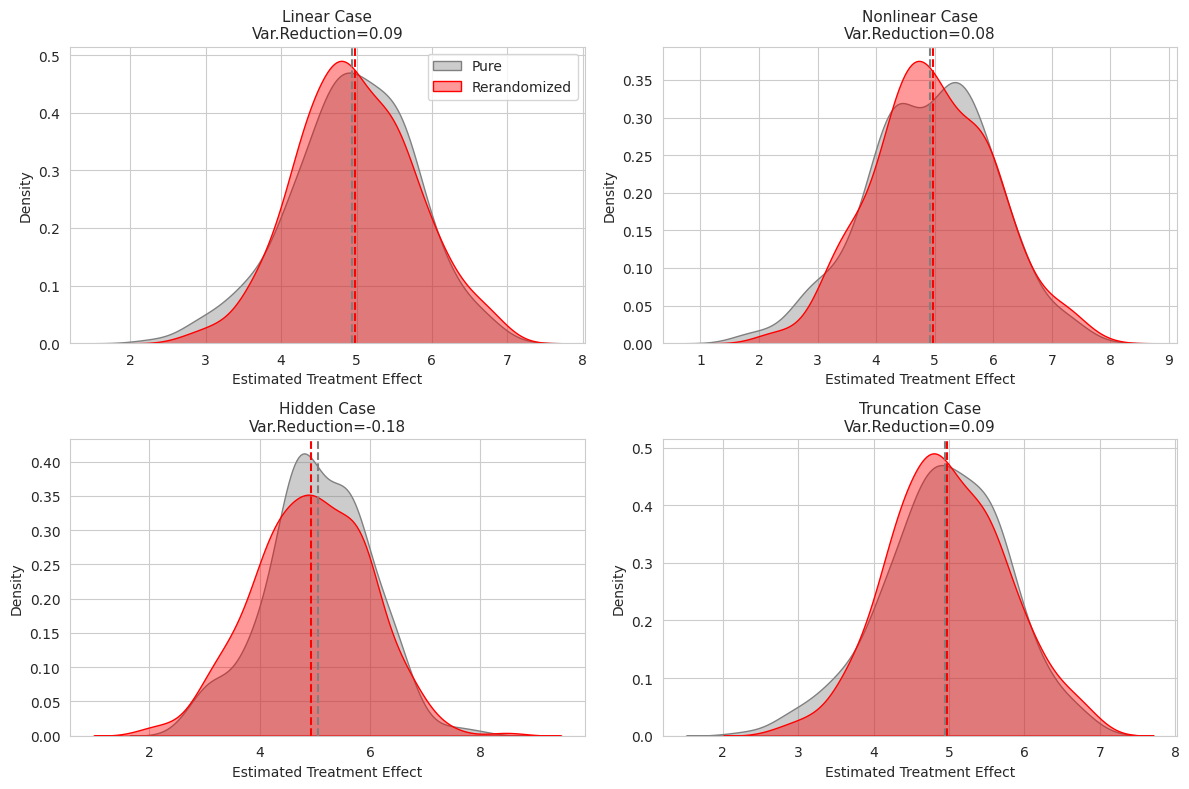

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from tqdm import trange

# ==============================================================
# === 1. Helper: generic simulation framework for given scenario ===
# ==============================================================

def simulate_case_with_existing_helpers(
    case="linear",
    n=200,
    k=8,
    true_effect=5.0,
    R_squared=0.6,
    pa=0.2,
    n_sims=300,
    seed=42
):
    np.random.seed(seed)

    # Storage for results
    results = []

    # Chi-squared threshold for acceptance
    a_threshold = chi2.ppf(pa, df=k)

    for _ in trange(n_sims, leave=False):
        # Step 1: Generate baseline data
        X, y_control, y_treat, cov_names = generate_data(
            n=n, k=k, true_effect=true_effect, R_squared=R_squared, seed=np.random.randint(1e6)
        )

        # Modify outcome or covariates depending on the case
        if case == "linear":
            y_control_case, y_treat_case = y_control, y_treat

        elif case == "nonlinear":
            # Add nonlinear relation between covariates and outcome
            y_control_case = y_control + 3 * np.sin(X[:, 0]) + 2 * (X[:, 1] ** 2)
            y_treat_case = y_control_case + true_effect

        elif case == "hidden":
            # Add unobserved prognostic variable Z
            Z = np.random.normal(0, 1, n)
            y_control_case = y_control + 4 * Z
            y_treat_case = y_control_case + true_effect

        elif case == "truncation":
            # Extremely small acceptance probability (overly strict)
            y_control_case, y_treat_case = y_control, y_treat
            a_threshold = chi2.ppf(0.01, df=k)  # pa = 0.01

        # Step 2: Pure randomization
        treat = np.random.binomial(1, 0.5, n)
        tau_pure, M_pure = randomization_test(X, y_control_case, y_treat_case, treat)

        # Step 3: Rerandomization
        treat_rerand, M_rerand, _ = rerandomize(X, a_threshold=a_threshold, max_iter=5000)
        tau_rerand, _ = randomization_test(X, y_control_case, y_treat_case, treat_rerand)

        # Step 4: Store results
        results.append({
            "tau_pure": tau_pure,
            "tau_rerand": tau_rerand,
            "M_pure": M_pure,
            "M_rerand": M_rerand
        })

    df = pd.DataFrame(results)
    return df


# ==============================================================
# === 2. Run the simulations for each case =====================
# ==============================================================

cases = ["linear", "nonlinear", "hidden", "truncation"]
case_results = {}

for case in cases:
    print(f"\nSimulating case: {case}")
    df_case = simulate_case_with_existing_helpers(case=case, pa=0.2, n_sims=300)
    case_results[case] = df_case


# ==============================================================
# === 3. Summarize results =====================================
# ==============================================================

summary = []
for case, df in case_results.items():
    var_reduction = 1 - df["tau_rerand"].var() / df["tau_pure"].var()
    summary.append({
        "Case": case,
        "Mean τ (pure)": np.mean(df["tau_pure"]),
        "Mean τ (rerand)": np.mean(df["tau_rerand"]),
        "Var(τ pure)": np.var(df["tau_pure"]),
        "Var(τ rerand)": np.var(df["tau_rerand"]),
        "Variance Reduction": var_reduction,
        "Mean M (pure)": np.mean(df["M_pure"]),
        "Mean M (rerand)": np.mean(df["M_rerand"])
    })

summary_df = pd.DataFrame(summary)
print("\nSummary of results:")
print(summary_df.round(3))


# ==============================================================
# === 4. Visualize distributions ===============================
# ==============================================================

plt.figure(figsize=(12, 8))
for i, case in enumerate(cases):
    df = case_results[case]
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df["tau_pure"], label="Pure", color="gray", fill=True, alpha=0.4)
    sns.kdeplot(df["tau_rerand"], label="Rerandomized", color="red", fill=True, alpha=0.4)
    plt.axvline(df["tau_pure"].mean(), color="gray", linestyle="--")
    plt.axvline(df["tau_rerand"].mean(), color="red", linestyle="--")
    plt.title(
        f"{case.capitalize()} Case\nVar.Reduction={summary_df.loc[i, 'Variance Reduction']:.2f}",
        fontsize=11
    )
    plt.xlabel("Estimated Treatment Effect")
    plt.ylabel("Density")
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()


---

## 6. Power Analysis <a id='power'></a>

Now let's compare the statistical power of different approaches:
1. Pure randomization
2. Rerandomization with different acceptance rates

We'll simulate many trials and see how often each method correctly detects the true effect.

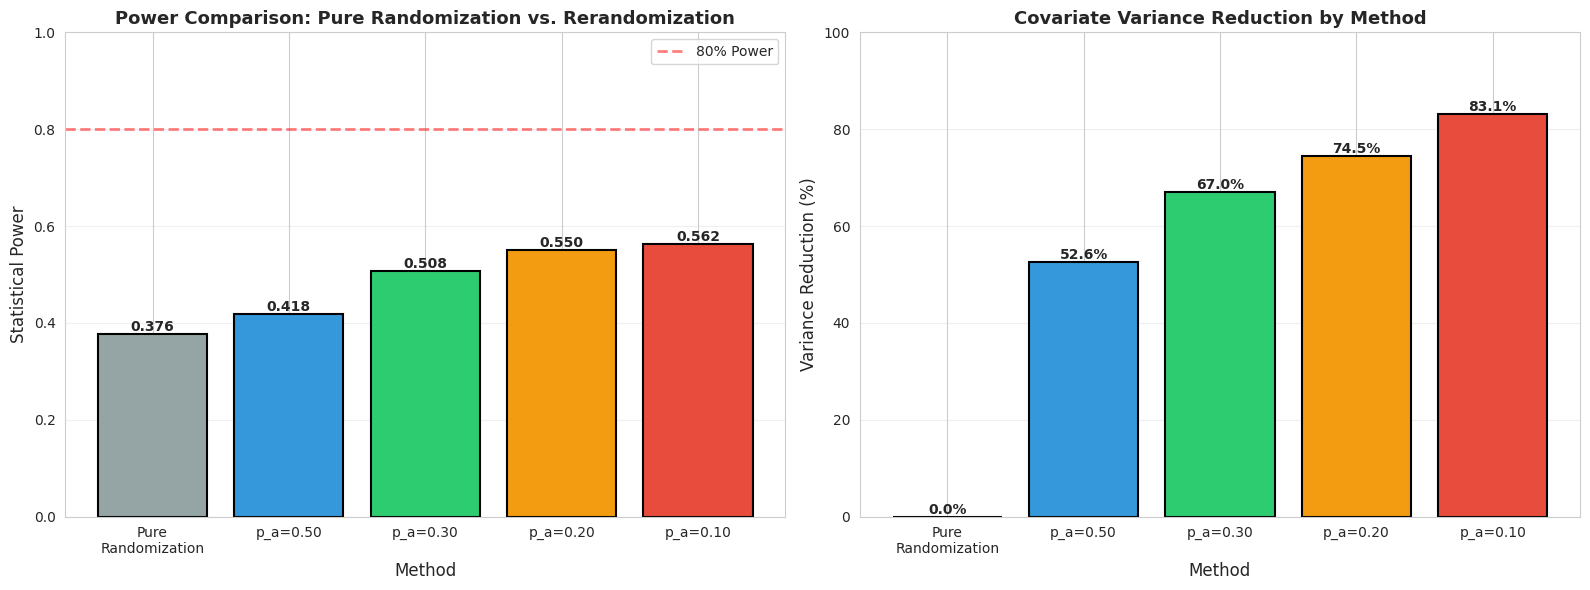


📊 Key Insights:
  • Pure randomization power: 0.376
  • Best rerandomization power: 0.562 (p_a = 0.1)
  • Power increase: 49.5%
  • More stringent acceptance criteria (lower p_a) → Higher power!


In [12]:
# Visualize power comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Power comparison
ax = axes[0]
colors = ['#95A5A6', '#3498DB', '#2ECC71', '#F39C12', '#E74C3C']
bars = ax.bar(range(len(powers)), powers, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Statistical Power', fontsize=12)
ax.set_title('Power Comparison: Pure Randomization vs. Rerandomization',
             fontsize=13, fontweight='bold')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=0)
ax.set_ylim([0, 1])
ax.axhline(0.8, color='red', linestyle='--', linewidth=2, alpha=0.5, label='80% Power')
ax.grid(alpha=0.3, axis='y')
ax.legend()

# Add value labels on bars
for bar, power in zip(bars, powers):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{power:.3f}',
            ha='center', va='bottom', fontweight='bold')

# Variance reduction
ax = axes[1]
v_a_values = [calculate_v_a(k, p_a) for p_a in p_a_values]
var_reductions = [(1 - v_a) * 100 for v_a in v_a_values]

bars = ax.bar(range(len(var_reductions)), var_reductions, color=colors,
              edgecolor='black', linewidth=1.5)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Variance Reduction (%)', fontsize=12)
ax.set_title('Covariate Variance Reduction by Method',
             fontsize=13, fontweight='bold')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=0)
ax.set_ylim([0, 100])
ax.grid(alpha=0.3, axis='y')

# Add value labels
for bar, reduction in zip(bars, var_reductions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{reduction:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Key Insights:")
print(f"  • Pure randomization power: {powers[0]:.3f}")
print(f"  • Best rerandomization power: {max(powers):.3f} (p_a = {p_a_values[np.argmax(powers)]})")
print(f"  • Power increase: {(max(powers) - powers[0])/powers[0] * 100:.1f}%")
print(f"  • More stringent acceptance criteria (lower p_a) → Higher power!")

### Effect of R² on Power Gains

---

## 7. Complete Comparison: Pure vs. Rerandomization <a id='comparison'></a>

Let's do a comprehensive side-by-side comparison.

In [14]:
# Compare distributions of Mahalanobis distances
print("="*70)
print("DISTRIBUTION OF MAHALANOBIS DISTANCES")
print("="*70)
print("\nGenerating 1000 randomizations for each method...\n")

# Pure randomization: generate many random assignments
M_pure_dist = []
for _ in range(1000):
    W_temp = np.zeros(n)
    treat_indices = np.random.choice(n, size=n_treat, replace=False)
    W_temp[treat_indices] = 1
    M_temp = calculate_mahalanobis_distance(X, W_temp)
    M_pure_dist.append(M_temp)

M_pure_dist = np.array(M_pure_dist)

# Rerandomization: only keep accepted ones
p_a_compare = 0.20
threshold_compare = chi2.ppf(p_a_compare, df=k)
M_rerand_dist = []

attempts = 0
while len(M_rerand_dist) < 1000:
    attempts += 1
    W_temp = np.zeros(n)
    treat_indices = np.random.choice(n, size=n_treat, replace=False)
    W_temp[treat_indices] = 1
    M_temp = calculate_mahalanobis_distance(X, W_temp)

    if M_temp <= threshold_compare:
        M_rerand_dist.append(M_temp)

M_rerand_dist = np.array(M_rerand_dist)

print(f"Pure randomization:")
print(f"  Mean M: {M_pure_dist.mean():.3f}")
print(f"  Std M: {M_pure_dist.std():.3f}")
print(f"  Range: [{M_pure_dist.min():.3f}, {M_pure_dist.max():.3f}]")

print(f"\nRerandomization (p_a = {p_a_compare}):")
print(f"  Mean M: {M_rerand_dist.mean():.3f}")
print(f"  Std M: {M_rerand_dist.std():.3f}")
print(f"  Range: [{M_rerand_dist.min():.3f}, {M_rerand_dist.max():.3f}]")
print(f"  Required {attempts} attempts to get 1000 acceptable (acceptance rate: {1000/attempts:.3f})")

DISTRIBUTION OF MAHALANOBIS DISTANCES

Generating 1000 randomizations for each method...

Pure randomization:
  Mean M: 3.917
  Std M: 2.652
  Range: [0.137, 16.147]

Rerandomization (p_a = 0.2):
  Mean M: 1.029
  Std M: 0.397
  Range: [0.020, 1.648]
  Required 5244 attempts to get 1000 acceptable (acceptance rate: 0.191)


### Summary Table

## Conclusion

### When Should You Use Rerandomization?

✅ **YES, use rerandomization when:**
- You have baseline covariate data before the experiment
- Covariates are likely predictive of the outcome (moderate to high R²)
- You want more precise estimates and higher power
- You can pre-specify the balance criterion
- You can perform randomization tests for analysis

❌ **NO, don't bother when:**
- Covariates are unrelated to the outcome (R² ≈ 0)
- You can't collect covariate data before randomization
- Sample size is so large that balance is guaranteed

### Further Reading

- Morgan, K. L., & Rubin, D. B. (2012). Rerandomization to improve covariate balance in experiments. *Annals of Statistics*, 40(2), 1263-1282.
- Li, X., Ding, P., & Rubin, D. B. (2018). Asymptotic theory of rerandomization in treatment-control experiments. *PNAS*, 115(37), 9157-9162.
